In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as img
from PIL import ImageDraw,ImageFont


class IO:
    '''IO includes all static methods.'''

    COLORS = {
        'verde': '#00C000',
        'rosa': '#FF00FF',
        'cian': '#00FFFF',
        'rojo': '#FF0000',
        'azul': '#0000FF'
    }

    # In cm-1
    PEAK_RANGE = 25
    PEAK_POSITIONS = {'D_peak': 1350, 'G_peak': 1580, 'D_prime_peak': 1620,
                      'D2_peak': 2690, 'D_G_peak': 2940}
    
    def __init__(self, global_path):
        '''Generates paths of interest.'''
        IO.global_path = os.path.abspath(global_path)
        IO.parent_path = os.path.dirname(global_path)

        # New directories
        extra_paths = ["Images", "Data",
                       "Graphs", "Concatenated Graphs"]
        for path in extra_paths:
            new_dir = os.path.join(IO.global_path, path)
            os.makedirs(new_dir, exist_ok=True)
        os.makedirs(os.path.join(IO.parent_path, 'Catalog'), exist_ok=True)
        
        IO.img_path = os.path.join(global_path, extra_paths[0])
        IO.data_path = os.path.join(global_path, extra_paths[1])
        IO.graph_path = os.path.join(global_path, extra_paths[2])
        IO.concat_path = os.path.join(global_path, extra_paths[3])
        IO.catalog_path = os.path.join(IO.parent_path, 'Catalog')

        IO.sort_paths(IO.global_path)

    
    @staticmethod
    def sort_paths(path):
        listdir = os.listdir(path)
        for f in listdir:
            if f.endswith('.png'):
                os.rename(os.path.join(path, f), os.path.join(IO.img_path, f))
            if f.endswith('.txt'):
                os.rename(os.path.join(path, f), os.path.join(IO.data_path, f))

                
    @staticmethod
    def extract_name(string, **kargs):
        '''
        Assumes dash separated string of the form:
            [sample_name]_[magnification]_[zone_name].png or
            [sample_name]_[magnification]_[zone_name]_[color].txt
        Extracted strings are returned in the order in which kargs are typed.
        '''
        # Está un poco confuso, pero lo pongo para que si en algún
        # momento cambia la convención sólo tengamos que mover esto.
        indeces = {'sample_name': 0, 'magnification': 1, 'zone_name': 2, 'color': 3}
        variables = set(['sample_name', 'magnification', 'zone_name', 'color'])
        splitted = string.split('_')
        
        if not set(kargs.keys()) <= variables:
            raise ValueError("Unrecognized arguments. Use: sample_name, magnification,"
                             "zone_name, color.")

        extracted_strings = []
        for key in kargs:
            if kargs[key]:
                # What's below works for both .png, .txt as written above.
                if key=='zone_name':
                    extracted = splitted[2].replace('.png', '')
                    extracted_strings.append(extracted)
                    continue
                if key=='color':
                    extracted = splitted[3].replace('.txt', '')
                    extracted_strings.append(extracted)
                    continue
                extracted_strings.append(splitted[indeces[key]])
                # ↑ 押しゴリ wwwwwwww
        return extracted_strings
            
                
    @staticmethod
    def extract_data(filename):
        '''
        Headers
        -------
            shift: Raman shift in wavenumber
            intensity: intensity in arbitrary units.
        '''
        names = ['shift', 'intensity']
        raman_df = pd.read_csv(filename, names=names, sep='\t')
        return raman_df


    @staticmethod
    def get_peak_maxima(raman_shift, arb_intensity):
        for peak_name in IO.PEAK_POSITIONS:
            peak_pos = IO.PEAK_POSITIONS[peak_name]
            filtered_intensity = arb_intensity[raman_shift < (peak_pos + IO.PEAK_RANGE)]
            filtered_intensity = filtered_intensity[raman_shift > (peak_pos - IO.PEAK_RANGE)]
            peak_maximum = np.max(filtered_intensity)
            print(peak_maximum)
            

    
    @staticmethod
    def graph_graphene(filename, raman_shift, arb_intensity, color_name='blue', show=False):
        # filename ya llegua sin .txt, desde graph_data de Zone.
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(raman_shift, arb_intensity, linewidth=1,
                label='Espectro del Grafeno', color=IO.COLORS[color_name])
        
        ax.set_title(filename)
        ax.set_ylabel('Intensity [Arbs]')
        ax.set_xlabel('Raman Shift [cm^-1]')
        ax.legend()
        ax.grid()
    
        filename = filename + '.png'
        file_path = os.path.join(IO.graph_path, filename)
        plt.savefig(file_path)
        
        if not show:
            plt.close()
        plt.show()
        # Regresamos fig para guardarla y no tener que volver a graficar.
        return fig

    
    @staticmethod
    def show_fig(fig):
        '''Shows figure.'''
        # stackoverflow.com/questions/31729948/
        dummy = plt.figure()
        new_manager = dummy.canvas.manager
        new_manager.canvas.figure = fig
        fig.set_canvas(new_manager.canvas)
        plt.show()

    
    @staticmethod
    def imshow_image(pil_img, axis_off=True):
        '''Show image through Matplotlib's imshow.'''
        fig, ax = plt.subplots()
        ax.imshow(pil_img)
        if axis_off:
            plt.axis("off")
        plt.show()


class Batch(object):
    '''Batch of samples.'''
    def __init__(self, name, date=None):
        '''
        Parameters
        ----------
        name: str
            Name for the catalogue.
        date: str
            Defaults to None. Date when batch of samples was analyzed.

        Assignments
        -----------
        Assings self.name, self.global_path, self.date.
        In addition:

        self.samples: dict
            Dictionary of Sample classes.
        '''
        self.name = name
        self.date = date
        self.get_samples()


    def get_samples(self):
        '''Gets sample names and generates sample classes for sample.'''
        listdir = os.listdir(IO.img_path)
        sample_names = list({IO.extract_name(f, sample_name=True)[0] for f in listdir})
        items = [Sample(sample_name, date=self.date) for sample_name in sample_names]
        self.samples = dict([(z, i) for z, i in zip(sample_names, items)])

    
    def graph_sample_data(self):
        '''Graphs all sample's zones data.'''
        for sample_name in self.samples:
            self.samples[sample_name].graph_zone_data()


    def generate_catalog_entries(self):
        for sample_name in self.samples:
            self.samples[sample_name].generate_catalog_entries()


    def anex_to_catalog(self):
        # Aún seguí dejando dos funciones.
        for sample_name in self.samples:
            self.samples[sample_name].anex_to_catalog()

    
    def __getitem__(self, item):
        return self.samples[item]


class Sample(Batch):
    def __init__(self, name, date=None):
        '''
        Parameters
        ----------
        name: str
            Name of the sample as found on files (e.g. Muestra 1).
            
        Assignments
        -----------
        Assings self.name, self.global_path, self.date.
        In addition:

        self.zones: dict
            Dictionary of Zone classes.
        '''
        self.name = name
        self.date = date
        self.get_zones()

    
    def get_zones(self):
        '''Gets zone names and generates zone classes for sample.'''
        # First we get all the zone names associated to sample.
        # I'll use the Image directory, but anything works as I'll take
        # a set to avoid repetitions.
        listdir = os.listdir(IO.img_path)
        criteria = lambda f: self.name in f
        filtered_filenames = filter(criteria, listdir)
        zone_names = list({IO.extract_name(f, zone_name=True)[0] for f in filtered_filenames})
        
        items = [Zone(self.name, zone_name)
                     for zone_name in zone_names]
        self.zones = dict([(z, i) for z, i in zip(zone_names, items)])

    
    def graph_zone_data(self):
        '''Graphs all zones data.'''
        for zone_name in self.zones:
            self.zones[zone_name].graph_data()


    def generate_catalog_entries(self):
        for zone_name in self.zones:
            self.zones[zone_name].generate_catalog_entry()
            

    def anex_to_catalog(self):
        for zone_name in self.zones:
            zone = self.zones[zone_name]
            catalog_entry = img.new("RGB", (2480, 3508),color = (255,255,255))
            img_name = zone.img_names[0]
            
            image = img.open(os.path.join(IO.img_path, img_name))
            concat_graphs = img.open(zone.concat_graph_name)
            catalog_entry.paste(image, (240, 450))
            catalog_entry.paste(concat_graphs, (240, 1100))
            
            title = ImageDraw.Draw(catalog_entry)
            title_font = ImageFont.truetype(r'..\Fonts\timesbd.ttf', 80)
            subtitle_font = ImageFont.truetype(r'..\Fonts\times.ttf', 80)
            title.text((240,240),"Muestras " + self.date, fill = "black", font=title_font,allign="left")
            title.text((240,320),self.name +"_"+ zone.name,fill = "black", font=subtitle_font,allign="left")
            
            entry_name = os.path.join(IO.catalog_path, self.name + '_catalogo_' + zone.name + '.png')
            catalog_entry.save(entry_name)

    
    def __getitem__(self, item):
        return self.zones[item]


class Zone(Sample):
    def __init__(self, sample_name, name,
                 img_names=[], data_names=[], auto=True):
        '''
        Parameters
        ----------
        sample_name: str
            Name of sample to which zone belongs.
        name: str
            Name of the zone (e.g. Zona 1).
        img_names: array-like
            List of filenames for each image of zone. Expects only one image, but
            will work with more.
        data_names: array-like
            List of filenames for Raman data of zone, may be more than one and be
            classified with color.
        auto: bool
            True is default. Recommended to use when working on the global_path instead
            of providing each of the above arrays.

        Assignments
        -----------
        Assigns name, global_path, img_names, data_names to their corresponding
        class attributes.
        In addition:
        
        self.graph_names: array-like
            Filenames for generated graphs.
        self.figs: matplotlib.figure.Figure
            List of copies of generated figures. Avoids having to replot data in
            order to visualize through the use of staticmethod show_fig.
        '''
        self.sample_name = sample_name
        self.name = name
        self.img_names = img_names
        self.data_names = data_names
        self.graph_names = []
        self.concat_graph_name = ""
        self.figs = []
        # concat_graph_names sólo se general después de concatenar.
        
        # Dejo la opción de cargar los names a mano, pero la idea es usar
        # get_names para que sea automático.
        if auto:
            self.get_names()
            self.graph_data()


    def get_names(self):
        '''
        Gets image and data names for zone. Will clear old names.
        '''
        # Asumo una correspondencia 1-1 entre imagen y nombre de zona.
        # (Aunque si no es el caso, no pasa mucho, sólo que cada zona
        # tendrá más de una imagen)
        # Criteria for selecting file is having both the sample name and the
        # zone name in it.
        criteria = lambda f: (self.sample_name in f) and (self.name in f)
        self.img_names = list(filter(criteria, os.listdir(IO.img_path)))
        self.data_names = list(filter(criteria, os.listdir(IO.data_path)))
        self.data_df = {"".join(IO.extract_name(data_name, magnification=True, color=True)) : IO.extract_data(os.path.join(IO.data_path, data_name))
                        for data_name in self.data_names}


    def graph_data(self, lower_bound=1200, shows=[]):
        '''
        Graphs zone data. Appends filenames of generated graphs to
        self.graph_names and Matplotlib figures to self.figs.
        '''
        # Show es una lista de bools que permite elegir
        # qué gráficas mostrar. Por default no muestra nada.
        self.graph_names = []
        if not shows:
            shows = [False] * len(self.data_names)
            
        for data_name, show in zip(self.data_names, shows):
            raman_df = IO.extract_data(os.path.join(IO.data_path, data_name))
            raman_shift = raman_df['shift'][raman_df['shift']>lower_bound]
            arb_intensity = raman_df["intensity"][raman_df['shift']>lower_bound]
            
            # Si en graph_graphene extraes el color de data_name
            # ya tienes colores o7
            data_name = data_name.replace('.txt', '')
            color_name = IO.extract_name(data_name, color=True)[0]
            fig = IO.graph_graphene(data_name, raman_shift, arb_intensity,
                                    color_name=color_name, show=show)

            self.graph_names.append(data_name + '.png')
            self.figs.append(fig)


    def generate_catalog_entry(self):
        '''Generates and saves catalogue entry.'''
        concat_graphs_img = img.new("RGB", (2000, 500 * len(self.data_names)))
        for i, graph_name in enumerate(self.graph_names):
            graph_path = os.path.join(IO.graph_path, graph_name)
            graph_img = img.open(graph_path)
            concat_graphs_img.paste(graph_img, (0, 500*i))
        filename = f"{self.sample_name}_{self.name}_concatenado.png"
        concat_name = os.path.join(IO.concat_path, filename)
        concat_graphs_img.save(concat_name)
        self.concat_graph_name = concat_name

    
    def show_img(self):
        '''
        Shows each image for zone (usually one) through imshow.
        '''
        print(self.name)
        for img_name in self.img_names:
            img_path = os.path.join(IO.img_path, img_name)
            zone_image = img.open(img_path)
            IO.imshow_image(zone_image)

        
    def __str__(self):
        '''String representation of Zone.'''
        name = self.name
        img_names = self.img_names
        data_names = self.data_names
        return f"{name = }\n{img_names = }\n{data_names = }"


    def __getitem__(self, item):
        return self.data_df[item]


In [48]:
global_path = './Muestras_12-11-24'
IO(global_path)
name = 'Muestras 12-11-24'
date = '12-11-24'
batch = Batch(name, date)

In [49]:
batch.generate_catalog_entries()
batch.anex_to_catalog()

In [56]:
def get_peak_maxima(raman_shift, arb_intensity):
    peak_maxima = {}
    for peak_name in IO.PEAK_POSITIONS:
        peak_pos = IO.PEAK_POSITIONS[peak_name]
        filtered_intensity = arb_intensity[raman_shift < (peak_pos + IO.PEAK_RANGE)]
        filtered_intensity = list(filtered_intensity[raman_shift > (peak_pos - IO.PEAK_RANGE)])
        filtered_shift = raman_shift[raman_shift < (peak_pos + IO.PEAK_RANGE)]
        filtered_shift = list(raman_shift[raman_shift > (peak_pos - IO.PEAK_RANGE)])
        
        peak_index = filtered_intensity.index(np.max(filtered_intensity))
        peak_maxima[peak_name] = (filtered_shift[peak_index], filtered_intensity[peak_index])

    return peak_maxima

{'D_peak': 1350, 'G_peak': 1580, 'D_prime_peak': 1620, 'D2_peak': 2690, 'D_G_peak': 2940}


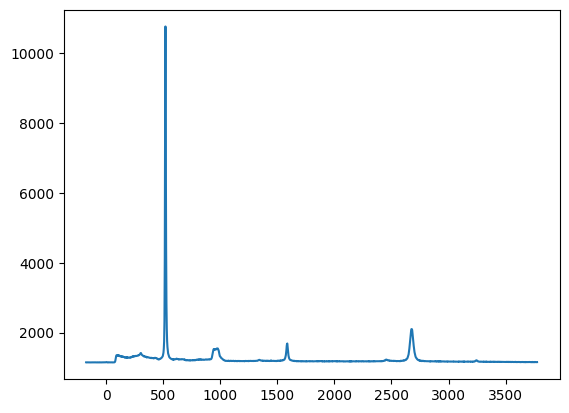

In [59]:
muestra1_zona3 = batch['Muestra 1']['zona3']
#for fig in muestra1_zona3.figs:
#    IO.show_fig(fig)
df = batch['Muestra 1']['zona3']['100xazul']
raman_shift = df['shift']
arb_intensity = df['intensity']

print(IO.PEAK_POSITIONS)
get_peak_maxima(raman_shift, arb_intensity)

fig, ax = plt.subplots()
ax.plot(raman_shift, arb_intensity)